# Using Naive Bayes to Predict What State You're From (If You Live in India)

In [65]:
import numpy as np
import pandas as pd
import requests

year = '2011'
api = lambda ep: f'http://digital-library.census.ihsn.org/index.php/api/tables/{ep}/{year}'
api_list = api('list')
api_info = lambda table: f"{api('info')}/{table}"
api_data = lambda table: f"{api('data')}/{table}"

In [70]:
# Create maps for state, district, 
# subdistrict, and town-village
# 0 means ALL
sdsdtv = pd.read_csv('data/PC11_TV_DIR.csv')

# States map
states = sdsdtv.loc[ (sdsdtv['District Code'] == 0) \
                    & (sdsdtv['Sub District Code'] == 0) \
                    & (sdsdtv['Town-Village Code'] == 0) ]
states = states[[
    'State Code', 
    'Town-Village Name'
]]
states = states.set_index('State Code')
states = states['Town-Village Name']
states.at[0] = 'ALL'
states = states.sort_index()
states = states.rename('State Name')

# Districts map
districts = sdsdtv.loc[ (sdsdtv['Sub District Code'] == 0) \
                    & (sdsdtv['Town-Village Code'] == 0) ]
districts = districts[[ 'District Code', 'Town-Village Name' ]]
districts = districts.drop_duplicates(subset=['District Code'])
districts = districts.set_index('District Code')
districts = districts['Town-Village Name']
districts.at[0] = 'All'
districts = districts.sort_index()
districts = districts.rename('District Name')

# Sub Districts map
sub_districts = sdsdtv.loc[ (sdsdtv['Town-Village Code'] == 0) ]
sub_districts = sub_districts[[
    'Sub District Code',
    'Town-Village Name'
]]
sub_districts = sub_districts.drop_duplicates(subset=['Sub District Code'])
sub_districts = sub_districts.set_index('Sub District Code')
sub_districts = sub_districts['Town-Village Name']
sub_districts.at[0] = 'All'
sub_districts = sub_districts.sort_index()
sub_districts = sub_districts.rename('Sub District Name')

# Town/Villages map
town_villages = sdsdtv[[ 'Town-Village Code', 'Town-Village Name' ]]
town_villages = town_villages.drop_duplicates(subset=['Town-Village Code'])
town_villages = town_villages.set_index('Town-Village Code')
town_villages = town_villages['Town-Village Name']
town_villages.at[0] = 'All'
town_villages = town_villages.sort_index()
town_villages = town_villages.rename('Sub District Name')

def get_dataset(table, query={}):
    url = api_data(table)
    query = '?' + '&'.join(f'{k}={v}' for k,v in query.items()) if query else ''
    info = requests.get(api_info(table)).json()
    features = info['result']['result_']['features']
    feature_map = { 
        feature['feature_name'] : { 
            c['code'] : c['label'] 
            for c in feature['code_list'] } 
        for feature in features }
    body = requests.get(url+query).json()
    df = pd.DataFrame(body['data'])
    df['state'] = df['state'].map(lambda r: states.at[r])
    df['district'] = df['district'].map(lambda r: districts.at[r])
    df['subdistrict'] = df['subdistrict'].map(lambda r: sub_districts.at[r])
    df['town'] = df['town'].map(lambda r: town_villages.at[r])
    for feature, labels in rps_feature_map.items():
        df[feature] = df[feature].map(lambda row: labels[row])
    return df

<AxesSubplot:ylabel='value'>

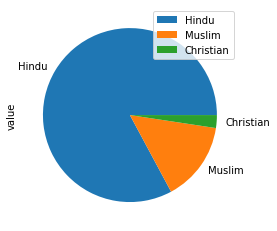

In [79]:
# Religions!
dataset = get_dataset('PC11_C01', { 
    'state': '0',
    'sex': '0',
    'urbrur': '0',
    'religion': '1,2,3'
})
dataset.set_index('religion').plot.pie(y='value')